In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 15.3MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 194kB 47.2MB/s 
     |████████████████████████████████| 1.1MB 52.8MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 40kB 7.7MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 2.6MB 46.3MB/s 


In [2]:
from fastai.vision.all import *

# Data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/08.obj'),Path('/root/.fastai/data/biwi_head_pose/03'),Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/readme.txt'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/12'),Path('/root/.fastai/data/biwi_head_pose/09.obj'),Path('/root/.fastai/data/biwi_head_pose/17.obj'),Path('/root/.fastai/data/biwi_head_pose/14')...]

In [6]:
def print_file(filepath):
  with open(filepath) as f:
    print(f.read())

In [8]:
print_file(path/'readme.txt')

Biwi Kinect Head Pose Database

This database is made available for non-commercial use such as university research and education.

We kindly ask you to cite the following reference in your publications related to this work:

@article{fanelli_IJCV,
  author = {Fanelli, Gabriele and Dantone, Matthias and Gall, Juergen and Fossati, Andrea and Van Gool, Luc},
  title = {Random Forests for Real Time 3D Face Analysis},
  journal = {Int. J. Comput. Vision},
  year = {2013},
  month = {February},
  volume = {101},
  number = {3},
  pages = {437--458}
}

The database contains 24 sequences acquired with a Kinect sensor. 20 people (some were recorded twice - 6 women and 14 men) were recorded while turning their heads, sitting in front of the sensor, at roughly one meter of distance.

For each sequence, the corresponding .obj file represents a head template deformed to match the neutral face of that specific person.
In each folder, two .cal files contain calibration information for the depth and t

The numbered subdirs contain images from one person each:

In [5]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00130_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00387_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00300_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00331_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00250_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00149_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00382_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00410_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00115_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00302_pose.txt')...]

In [9]:
print_file((path/'01')/'frame_00130_pose.txt')

0.899998 0.134378 -0.414664 
0.0507887 0.912488 0.405939 
0.432925 -0.386404 0.814412 

87.2191 18.3721 903.317 




I won't look into detail of what these coordinates mean.

In [11]:
for f in (path/'01').glob('*.jpg'):
  if '00130' in f.name:
    print(f)
    break

/root/.fastai/data/biwi_head_pose/01/frame_00130_rgb.jpg


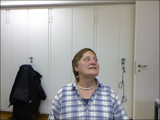

In [14]:
img = PILImage.create(f)
img.to_thumb(160)

In [19]:
img_files = get_image_files(path)
def img_to_pose(img_name): return Path(str(img_name).replace('rgb.jpg', 'pose.txt'))
img_to_pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/03/frame_00149_pose.txt')

In [24]:
calibration = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_center(f):
  center = np.genfromtxt(img_to_pose(f), skip_header=3)
  c1 = center[0] * calibration[0][0]/center[2] + calibration[0][2]
  c2 = center[1] * calibration[1][1]/center[2] + calibration[1][2]
  return tensor([c1, c2])

In [25]:
get_center(img_files[0])

tensor([383.6775, 241.7145])

Validation split so that a complete set for one person is used.

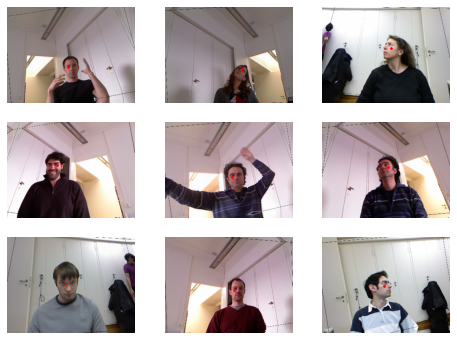

In [26]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_center,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [28]:
xb, yb = dls.train.one_batch()
xb.shape, yb.shape, yb[0]

(torch.Size([64, 3, 240, 320]),
 torch.Size([64, 1, 2]),
 TensorPoint([[-0.2612,  0.1302]], device='cuda:0'))

Coordinates are scaled to [-1,1], so we'll pass that when creating the learner.

In [29]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))
learn.loss_func

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=6.309573450380412e-07)

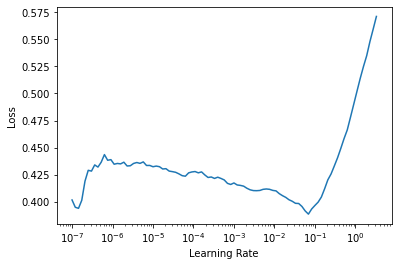

In [31]:
learn.lr_find()

In [32]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.044029,0.024923,02:04
1,0.006821,0.004695,02:04
2,0.003129,0.001201,02:03
3,0.002228,0.000316,02:02
4,0.001650,0.000633,02:03
